In [1]:
import h2o
from h2o.automl import H2OAutoML
import numpy as np
from sklearn.model_selection import train_test_split
import os
import time

In [2]:
h2o.init(ip = "localhost",
port = 54321,
start_h2o = True,
max_mem_size="16G",
nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.10+11-LTS-240, mixed mode, sharing)
  Starting server from C:\Users\aless\Documents\GitHub\ML-techniques-for-State-Estimation\venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\aless\AppData\Local\Temp\tmptqdgzi04
  JVM stdout: C:\Users\aless\AppData\Local\Temp\tmptqdgzi04\h2o_aless_started_from_python.out
  JVM stderr: C:\Users\aless\AppData\Local\Temp\tmptqdgzi04\h2o_aless_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Rome
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,2 months and 9 days
H2O_cluster_name:,H2O_from_python_aless_9p8ryi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,16 Gb
H2O_cluster_total_cores:,20
H2O_cluster_allowed_cores:,20
H2O_cluster_status:,"locked, healthy"


In [3]:
alt_x = np.load('../nets/net_18_data/measured_data_x_alt.npy')
alt_y = np.load('../nets/net_18_data/data_y_alt.npy')
data_x = alt_x
data_y = alt_y

split_train = int(0.8 * data_x.shape[0])
train_x = data_x[:split_train, :]
train_y = data_y[:split_train, :]

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=True, random_state=42)

train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.3, shuffle=True, random_state=42)


In [4]:
num_input = 53
num_output = 18

in_columns = [str(i) for i in range(num_input)]
out_columns = [str(i) for i in range(num_input, num_input + num_output)]

In [8]:
train_models = True
if train_models:
    for i in range(num_output):
        print(f'Training for output #{i}')
        train = np.hstack((train_x, train_y[:, i].reshape(-1, 1)))
        columns_names = in_columns + [out_columns[i]]
        train = h2o.H2OFrame(train, column_names=columns_names)
        
        x = in_columns
        y = out_columns[i]
        aml = H2OAutoML(max_models=3, seed=1, max_runtime_secs_per_model=180)
        aml.train(x=x, y=y, training_frame=train, )
        
        model_path = f'./h2o_models/model_{i}'
        aml = h2o.save_model(model=aml.leader, path=model_path, force=True)



Training for output #0
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
16:29:36.679: AutoML: XGBoost is not available; skipping it.
███████████████████████████████████████████████████████████████| (done) 100%
Training for output #1
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
16:30:15.225: AutoML: XGBoost is not available; skipping it.
███████████████████████████████████████████████████████████████| (done) 100%
Training for output #2
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
16:30:47.523: AutoML: XGBoos

In [25]:
test_predictions = []
for i in range(num_output):
    columns_names = in_columns + [out_columns[i]]
    x = in_columns
    y = out_columns[i]
    
    test = np.hstack((test_x, test_y[:, i].reshape(-1, 1)))
    test = h2o.H2OFrame(test, column_names=columns_names)
    
    model_path = f'./h2o_models/model_{i}/'
    files = os.listdir(model_path)
    model_filename = [f for f in files if os.path.isfile(os.path.join(model_path, f))][0]
    
    aml = h2o.load_model(f'{model_path}/{model_filename}')
    try:
        preds = aml.leader.predict(test)
    except:
        preds = aml.predict(test)
    test_predictions.append(preds['predict'])
    perf = aml.model_performance(test)
    print(f"MSE for model {i}: {perf._metric_json['MSE']}")
    print('---------------------------------')


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


KeyboardInterrupt: 

In [5]:
models = []
for i in range(num_output):
    model_path = f'./h2o_models/model_{i}/'
    files = os.listdir(model_path)
    model_filename = [f for f in files if os.path.isfile(os.path.join(model_path, f))][0]
    
    aml = h2o.load_model(f'{model_path}/{model_filename}')
    models.append(aml)
    print(f'Model {i} loaded')

Model 0 loaded
Model 1 loaded
Model 2 loaded
Model 3 loaded
Model 4 loaded
Model 5 loaded
Model 6 loaded
Model 7 loaded
Model 8 loaded
Model 9 loaded
Model 10 loaded
Model 11 loaded
Model 12 loaded
Model 13 loaded
Model 14 loaded
Model 15 loaded
Model 16 loaded
Model 17 loaded


In [ ]:
from net18.scenarios2 import get_data_by_scenario_and_case, report_preds_on_validation_files

std_results = []
for scenario in range(1, 6):
    for case in range(1, 4):
        print(f'SCENARIO {scenario}, CASE {case} VALIDATION')
        s1_c1_data = get_data_by_scenario_and_case(scenario, case)
        x = s1_c1_data[0]
        x_hat = s1_c1_data[1]
        y_all = s1_c1_data[2]
        y_hat_all = s1_c1_data[3]
        
        estim = []
        for i in range(num_output):
            columns_names = in_columns + [out_columns[i]]
            x = in_columns
            y = out_columns[i]
            
            aml = models[i]
            test_x = x_hat
            test_y = np.asarray(y_all[0][i]).reshape(-1, 1)
            test = h2o.H2OFrame(np.hstack((test_x, test_y)), column_names=columns_names)
            
            try:
                preds = aml.leader.predict(test)
            except:
                preds = aml.predict(test)
            estim.append(preds['predict'].as_data_frame().iloc[0][0])
            
        pred = np.asarray(estim)
        report_preds_on_validation_files(pred, 9, 'h2o', scenario, case=case)
        if case == 1:
            std_results.append(f'std: {np.sqrt(np.mean(np.square(y_all - pred)))}')
print(std_results)


In [7]:
pred = np.asarray(estim)
print(f'std: {np.sqrt(np.mean(np.square(y_all - pred)))}')

std: 0.008439554785042516


In [ ]:
# std res
['std: 0.008439554785042516', 'std: 0.006391693699890966', 'std: 0.004519067368293418', 'std: 0.0038331904856998235', 'std: 0.0013468433143673563']

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


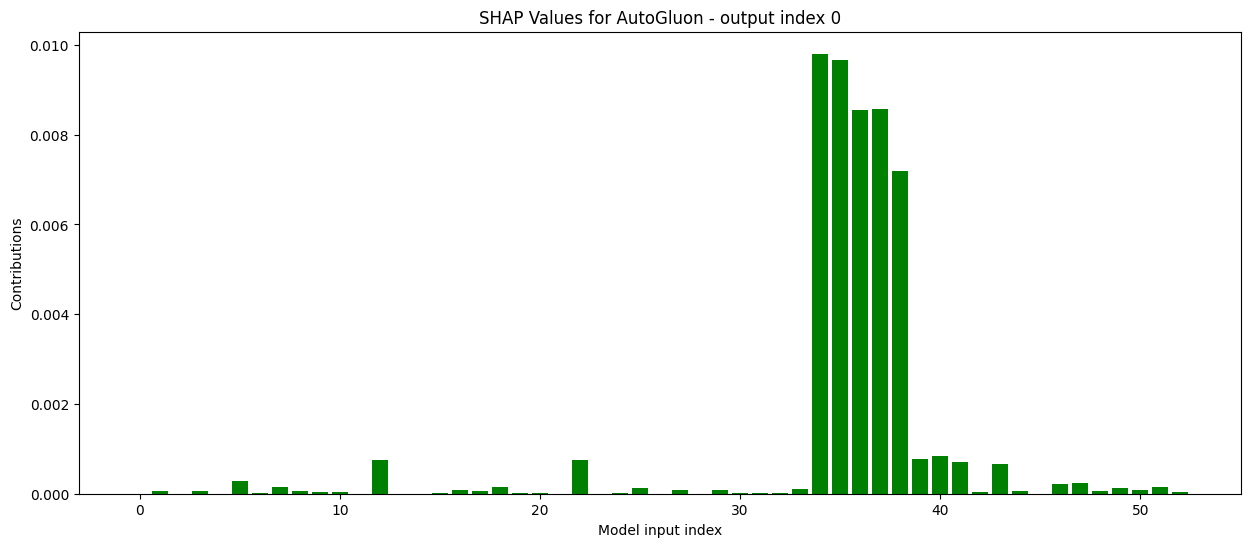

'\nnorm_relevance = ((relevance-abs(relevance)) / (max(relevance) - min(relevance)))\n\nprint(relevance)\nplt.imshow(norm_relevance.reshape((53, 1)))\nplt.colorbar()\n'

In [9]:
import shap
import pandas as pd

import matplotlib.pyplot as plt

np.random.seed(42)

node_index = 0
predictor = models[node_index] # I want to explain state estimation for node at index 0
columns_names = in_columns + [out_columns[node_index]]

def wrapped_model(x):
    x = h2o.H2OFrame(x)
    x.col_names = columns_names[:-1]
    preds = predictor.predict(x).as_data_frame().to_numpy()[:, 0]
    return preds


to_be_explained = test_x[0]
random_indices = np.random.choice(test_x.shape[0], size=100, replace=False)
explainer = shap.KernelExplainer(wrapped_model, train_x[random_indices])
shap_values = explainer.shap_values(to_be_explained)
relevance = abs(shap_values.ravel())

x_positions = np.arange(len(relevance))
plt.figure(figsize=(15,6))
plt.bar(x_positions, relevance, color='green')
plt.xlabel('Model input index')
plt.ylabel('Contributions')
plt.title(f'SHAP Values for AutoGluon - output index {node_index}')
#plt.xticks(x_positions, ['A', 'B', 'C', 'D', 'E'])

plt.show()

'''
norm_relevance = ((relevance-abs(relevance)) / (max(relevance) - min(relevance)))

print(relevance)
plt.imshow(norm_relevance.reshape((53, 1)))
plt.colorbar()
'''

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Intercept 0.9879654572887934
Prediction_local [1.03353641]
Right: 1.037437661638461


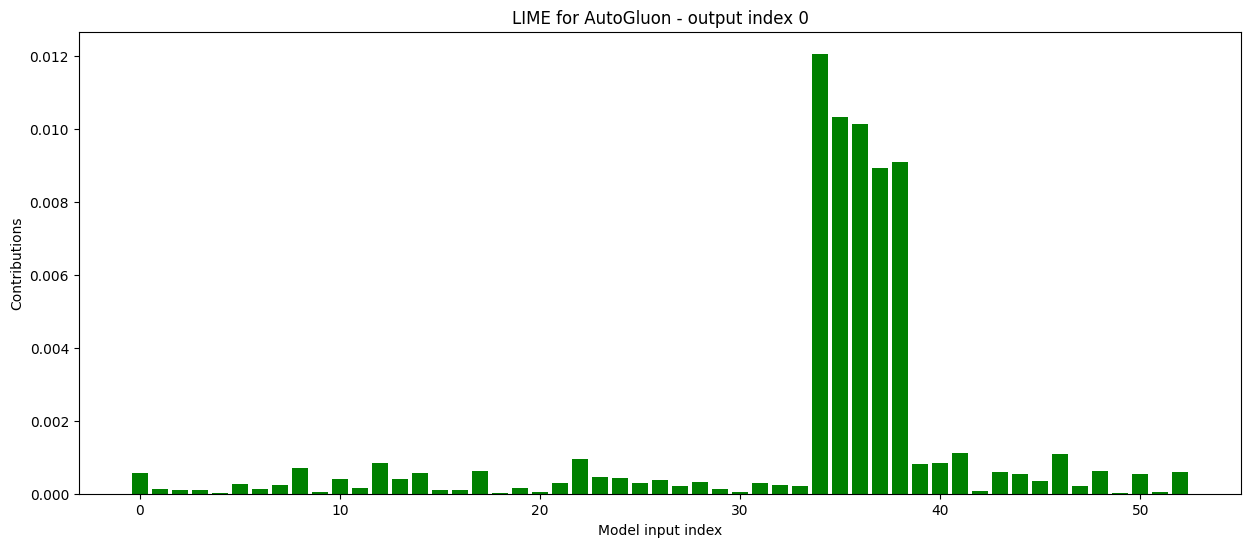

In [10]:
import lime.lime_tabular
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

node_index = 0
predictor = models[node_index] # I want to explain state estimation for node at index 0
columns_names = in_columns + [out_columns[node_index]]

def wrapped_model(x):
    x = h2o.H2OFrame(x)
    x.col_names = columns_names[:-1]
    preds = predictor.predict(x).as_data_frame().to_numpy()[:, 0]
    return preds

to_be_explained = test_x[0]
random_indices = np.random.choice(test_x.shape[0], size=100, replace=False)
background = train_x[random_indices]
explainer = lime.lime_tabular.LimeTabularExplainer(
    background,
    feature_names=columns_names[:-1],
    verbose=True,
    mode='regression'
)

exp = explainer.explain_instance(to_be_explained, wrapped_model, num_features=53)
relevance = abs(np.asarray([j for i,j in sorted(exp.local_exp[1], key=lambda i: i[0])]))

x_positions = np.arange(len(relevance))
plt.figure(figsize=(15,6))
plt.bar(x_positions, relevance, color='green')
plt.xlabel('Model input index')
plt.ylabel('Contributions')
plt.title(f'LIME for AutoGluon - output index {node_index}')
#plt.xticks(x_positions, ['A', 'B', 'C', 'D', 'E'])

plt.show()